In [1]:
# Import Rn data
import pandas as pd
import numpy as np
import os
import matplotlib as mp
import numpy as np
import plotly.plotly as py
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import plotly.plotly as py
import plotly.graph_objs as go
from matplotlib import pylab
from scipy.optimize import curve_fit

rn_samp = pd.read_pickle('/home/shawaf/calibration_data/pax_v6.6.5_rn_event_combine/170313_1055.pkl')

rn = pd.DataFrame(columns = list(rn_samp))
    
for filename in os.listdir('/home/shawaf/calibration_data/pax_v6.6.5_rn_event_combine/'):
    df = pd.read_pickle('/home/shawaf/calibration_data/pax_v6.6.5_rn_event_combine/' + str(filename))
    rn = rn.append(df)
    
rn = rn[rn.s2>200]

In [2]:
# building the csv instruct file from Rn data
want = ['x','y','z','cs1','cs2']
a = rn.dropna()[want]
a['z'] = -1 * a['z']

# simulator takes s2 electrons to determine s2
pe_per_e = 25
a['cs2'] = a['cs2'] / pe_per_e

#a.to_csv('~/data/er_ss_sim/er_ss_2_0/rnsim_2_0.csv')

#Then simulate w fax

In [3]:
# Load in sim data
import hax

# using modified version of Tianyu's OtherLargeS2s peak extractor
from make_minitree import Peaks

hax.init(experiment='XENON1T',
         use_runs_db=False,
         pax_version_policy='loose',
         main_data_paths=['~/data/er_ss_sim/er_ss_2_0'],
         minitree_paths = ['~/data/er_ss_sim/er_ss_2_0'])

INFO:hax.__init__] Not looking for datasets in runs, db since you put use_runs_db = False


In [4]:
sim = hax.minitrees.load("rn_sim_2_0",[Peaks])

DEBUG:hax.minitrees] Found minitree at /home/shawaf/data/er_ss_sim/er_ss_2_0/rn_sim_2_0_Peaks.root
DEBUG:hax.minitrees] Found minitree at /home/shawaf/data/er_ss_sim/er_ss_2_0/rn_sim_2_0_Peaks.root
DEBUG:hax.minitrees] Removing weird index column


In [5]:
sim.columns

Index(['cs1', 'cs2', 'event_number', 'run_number', 's1', 's2', 's2_1_area',
       's2_1_delay_is2', 's2_1_range_50p_area', 's2_1_x', 's2_1_y', 's2_1_z',
       's2_2_area', 's2_2_delay_is2', 's2_2_range_50p_area', 's2_2_x',
       's2_2_y', 's2_2_z', 's2_3_area', 's2_3_delay_is2',
       's2_3_range_50p_area', 's2_3_x', 's2_3_y', 's2_3_z', 's2_4_area',
       's2_4_delay_is2', 's2_4_range_50p_area', 's2_4_x', 's2_4_y', 's2_4_z',
       's2_5_area', 's2_5_delay_is2', 's2_5_range_50p_area', 's2_5_x',
       's2_5_y', 's2_5_z', 's2_delay_is2', 's2_range_50p_area', 'x', 'y', 'z'],
      dtype='object')

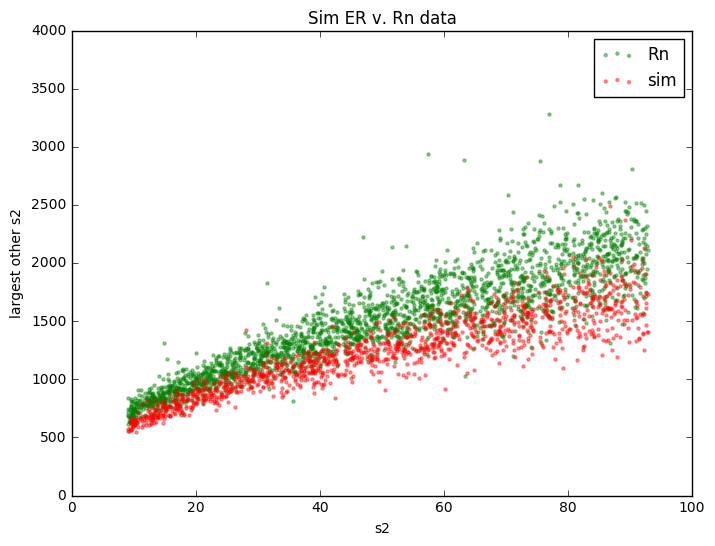

In [6]:
import matplotlib
import matplotlib.pyplot as plt


plt.figure(figsize=(8,6))
plt.scatter(-rn.z,rn.s2_range_50p_area,c='g',marker='.',alpha=0.4, edgecolors = 'g',label="Rn")
plt.scatter(-sim.z,sim.s2_range_50p_area,c='r',marker='.',alpha=0.4,  edgecolors = 'r',label = "sim")
plt.xlim(0,0.1e3)
plt.ylim(0,4e3)
plt.legend(loc = 'upper right')
plt.title('Sim ER v. Rn data')
plt.xlabel('s2')
plt.ylabel('largest other s2')
plt.show()

/home/shawaf/anaconda3/envs/pax/lib/python3.4/site-packages/numpy/lib/function_base.py:583: RuntimeWarning:

invalid value encountered in greater_equal

/home/shawaf/anaconda3/envs/pax/lib/python3.4/site-packages/numpy/lib/function_base.py:584: RuntimeWarning:

invalid value encountered in less_equal



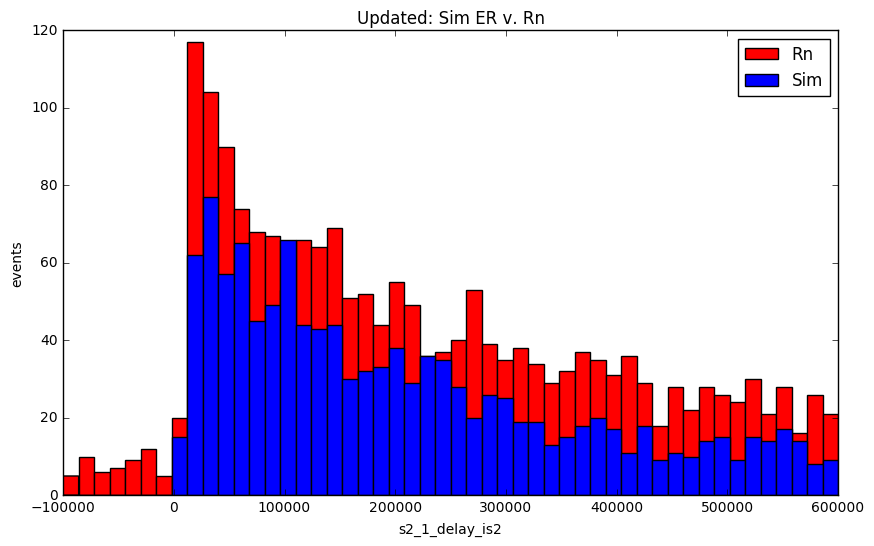

In [7]:
plt.figure(figsize=(10,6))
hist_rn, bins_rn, patches_rn = plt.hist(rn.s2_1_delay_is2,range = [-100e3, 600e3], color='r',bins = 50,label = 'Rn')
hist_sim, bins_sim, patches_sim = plt.hist(sim.s2_1_delay_is2,range = [-100e3, 600e3], bins = 50, label='Sim')
plt.title("Updated: Sim ER v. Rn")
plt.xlabel("s2_1_delay_is2")
plt.ylabel("events")

plt.legend()
plt.show()

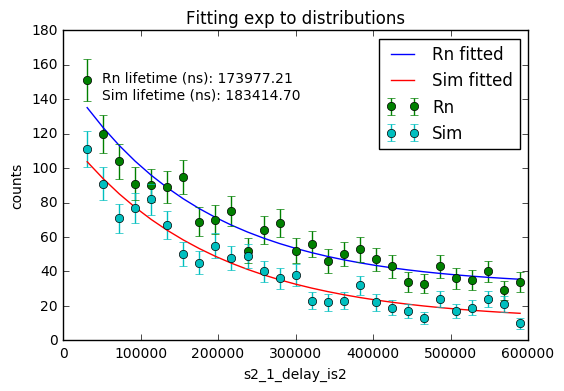

In [13]:
import pandas as pd
import matplotlib as mp
import numpy as np
import plotly.plotly as py
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import plotly.plotly as py
import plotly.graph_objs as go
from matplotlib import pylab
from scipy.optimize import curve_fit

def truncate(f, n):
    '''Truncates/pads a float f to n decimal places without rounding'''
    s = '{}'.format(f)
    if 'e' in s or 'E' in s:
        return '{0:.{1}f}'.format(f, n)
    i, p, d = s.partition('.')
    return '.'.join([i, (d+'0'*n)[:n]])

# --------------------- binning data to fit with exp

bins = np.linspace(0, 600000, 30)

binspace = (bins - bins[1]/2)[2:]

field = 's2_1_delay_is2'

rn_counts_s2_1_delay_is2 = []
rn_counts_s2_1_delay_is2_sigma = []

sim_counts_s2_1_delay_is2 = []
sim_counts_s2_1_delay_is2_sigma = []

# -------------------- counting entries in each bin

for i in range(2, len(bins)):
    a = rn.loc[(rn[field] < bins[i]) & (rn[field] > bins[i-1])]

    counts = a.shape[0]
    sigma = np.sqrt(float(counts))

    rn_counts_s2_1_delay_is2.append(counts)
    rn_counts_s2_1_delay_is2_sigma.append(sigma)
    
for i in range(2, len(bins)):
    a = sim.loc[(sim[field] < bins[i]) & (sim[field] > bins[i-1])]

    counts = a.shape[0]
    sigma = np.sqrt(float(counts))

    sim_counts_s2_1_delay_is2.append(counts)
    sim_counts_s2_1_delay_is2_sigma.append(sigma)

# ------------------- fitting    

    
def exp_func(x,a,b,c):
	return a*np.exp(-b*x)+c


popt, pcov = curve_fit(exp_func, binspace, rn_counts_s2_1_delay_is2, p0 = (100,1e-6,0))

yy = exp_func(binspace, *popt)

plt.plot(binspace,yy,'-', label = 'Rn fitted')
plt.errorbar(binspace,rn_counts_s2_1_delay_is2, yerr=rn_counts_s2_1_delay_is2_sigma,ls='None',marker='o', label = 'Rn')


sig_rn = repr(np.sqrt(pcov[1,1]))
lt_rn  = repr(1/popt[1])

popt, pcov = curve_fit(exp_func, binspace, sim_counts_s2_1_delay_is2, p0 = (100,1e-6,0))

yy = exp_func(binspace, *popt)

plt.plot(binspace,yy,'-',label = 'Sim fitted')
plt.errorbar(binspace,sim_counts_s2_1_delay_is2, yerr=sim_counts_s2_1_delay_is2_sigma,ls='None',marker='o',label = 'Sim')

sig_sim = repr(np.sqrt(pcov[1,1]))
lt_sim = repr(1/popt[1])
height = 140
plt.text(50000,height + 10,'Rn lifetime (ns): ' + str(truncate(lt_rn,2)))
plt.text(50000,height,'Sim lifetime (ns): ' + str(truncate(lt_sim,2)))
plt.title('Fitting exp to distributions')
plt.xlabel('s2_1_delay_is2')
plt.ylabel('counts')
plt.legend()
plt.show()

In [14]:
sig_rn

'8.4719125515395327e-07'

In [15]:
lt_sim

'183414.70134729525'